In [1]:
# import packages
import numpy as np
import random

import plotly.express as px
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import os

In [2]:
# set constants for background generation
L = 0.05 # length
H = 0.05 # height
dx = 0.0025
dy = 0.0025
tmax = 10
dt = 0.01 # change in time
epsilon = 0.0001

# set constants for anomalies
dI = 0.3 # intensity difference

save_path = "./samples"


In [7]:
# what is the Fo number?
NN = 1

# generate the random noise values
domainalp = np.array([])
for i in range(NN):
    domainalp = np.append(domainalp, 0.5e-5 + 1e-5 * random.random())

print(domainalp.shape)

CENTERT = [] # NN x 1
AVET = [] # NN x 1

# list of simulated data matrices
SimulateData = [] # NN x 10
SimulateDataNoNoise = []


(1,)


In [12]:
# create anomalies
# Y = M + A + E
x_dim = (int) (L / dx + 1)
y_dim = (int) (H / dx + 1)

# currently at no error
A = np.zeros((x_dim, y_dim))

# make it a set of anomalies directly along a diagonal axis
for i in range(x_dim):
        A[i][i] = 1e-5


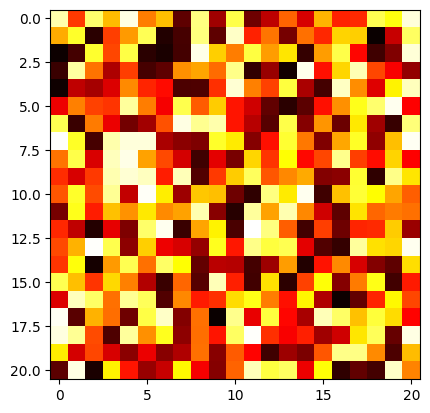

In [13]:
for iN in range(NN):
    directory = str(iN)
    directory_path = os.path.join(save_path, directory)


    # if (not os.path.exists(directory_path)):
        # os.makedirs(directory_path)

    # generate the noise values
    r_x = domainalp[iN] * dt/(pow(dx, 2))
    r_y = domainalp[iN] * dt/(pow(dy, 2))
    fo = r_x + r_y

    # what does this condition mean? no convergence?
    if fo > 0.5000:
        raise Exception("Numerical stability requires Fo <= 1/2")
        exit()

    # we create a matrix of values
    nx = (int) (L / dx + 1)
    ny = (int) (H / dx + 1)

    grid = np.empty((nx, ny))

    # find center
    ic = (int) ((nx - 1) / 2) # no plus one, index starts at 0
    jc = (int) ((ny - 1) / 2)

    # set boundary conditions
    T = np.zeros((nx, ny))

    # column 0
    T[:,0] = 1

    # column ny - 1
    T[:, ny-1] = 1

    # row 0
    T[0, :] = 1

    # row nx - 1
    T[nx - 1, :] = 1

    # I had difficulty telling what this step does?? are they not 0 and 1?)
    Tmin = np.min(np.min(T)) 
    Tmax = np.max(np.max(T)) 
    
    # iterative component
    n = 0 # index

    # nmax = (int) (tmax/dt)
    nmax = 1000

    CenterT = [] # center temperature
    AveT = []
    SaveIndex = 0
    iSave = 0
    bSaveImage = 0

    fig = plt.figure()

    while n < nmax:
            file_path = directory_path + "/" + str(n)

            n = n + 1
            SaveIndex = SaveIndex + 1

            T_n = T
            T_anomalies = T

            # define temperature values
            for j in range(1, nx - 1):
                for i in range(1, nx - 1):
                     T[j][i]= T_n[j][i] + r_x*(T_n[j][i+1]-2*T_n[j][i]+T_n[j][i-1]) + r_y*(T_n[j+1][i]-2*T_n[j][i]+T_n[j-1][i])
                     T_anomalies = T[j][i] + A[i][j] * dI

            a = T.shape
            NoiseT = T + 0.1 * np.random.rand(a[0], a[1])
            # NoiseT_anomalies = T_anomalies + 0.1 * np.random.rand(a[0], a[1])

            # plt.imshow(NoiseT_anomalies, cmap='hot', interpolation='nearest')

            plt.imshow(NoiseT, cmap='hot', interpolation='nearest')
        
            # plt.axis('off')
            # plt.savefig(file_path, bbox_inches='tight', pad_inches=0)

            # df = pd.DataFrame(NoiseT)

    # plt.figure()
    # heatmap = sns.heatmap(df.corr(), vmin = 0.0, vmax = 1.0, xticklabels = False, yticklabels = False, cbar = True)

    # fig = heatmap.get_figure()
    # fig.savefig("sample_plot2.png")
   
    
            

    
    